# Phase estimation with QCNN (N = 8)

Reproducing results from: https://arxiv.org/abs/1906.10155

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
##############


In [2]:
dev_vqe = qml.device('default.qubit', wires=8)

## States preparation through VQE

In [3]:
###################
## VQE FUNCTIONS ##
###################

def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
        
    # Ising Ring
    # H = H + J*(-1)*( qml.PauliX(0) @ qml.PauliX(N-1) )
    
    return H

def vqe_circuit_1(param, N = 8):
    '''
    Build the circuit to find the Groud-State of the 
    Ising-Chain Hamiltonian
    '''
    for spin in range(N):
        qml.RY(param[spin], wires = spin)
        qml.RX(param[N+spin], wires = spin)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
    
    qml.Barrier()
    
    for spin in range(N):
        qml.RY(param[2*N   + spin], wires = spin)
        qml.RX(param[3*N   + spin], wires = spin)
    
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
        
    for spin in range(N):
        qml.RY(param[4*N + spin], wires = spin)
        
def vqe_circuit_2(param, N = 8):
    '''
    Build the circuit to find the Groud-State of the 
    Ising-Chain Hamiltonian
    '''
    qml.RY(param[0], wires = 0)
    qml.RX(param[1], wires = 0)
    
    qml.RY(param[2], wires = N - 1)
    qml.RX(param[3], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RY(param[4], wires = spin)
        qml.RY(param[5], wires = spin+1)
        qml.RX(param[6], wires = spin)
        qml.RX(param[7], wires = spin+1)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
    
    qml.Barrier()
    
    qml.RY(param[8], wires = 0)
    qml.RX(param[9], wires = 0)
    
    qml.RY(param[10], wires = N - 1)
    qml.RX(param[11], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RY(param[12], wires = spin)
        qml.RY(param[13], wires = spin+1)
        qml.RX(param[14], wires = spin)
        qml.RX(param[15], wires = spin+1)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
     
    qml.RX(param[16], wires = 0)
    qml.RX(param[17], wires = N - 1)
    
    qml.RY(param[18], wires = 0)
    qml.RY(param[19], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RX(param[20], wires = spin)
        qml.RX(param[21], wires = spin+1)
        qml.RY(param[22], wires = spin)
        qml.RY(param[23], wires = spin+1)
        
def show_params_ising_chain(thetas_arr):
    '''
    thetas_arr: array of the following structure:
                    list( (J_value, angles of the circuit (vqe_ising_chain_circuit) ) )
    '''
    for J in range(len(thetas_arr)):
        plt.title('J = {0}'.format(thetas_arr[J][0])) 

        pm = plt.imshow(np.abs(thetas_arr[J][1]))

        for i in range(np.shape(thetas_arr[J][1])[1]):
            plt.axvline(x=i - .5, color = 'black')

        plt.ylabel(r'$\lambda$')

        plt.colorbar(pm, shrink=0.3, aspect=20)
        plt.tight_layout()
        plt.show()    
        
def train_vqe_ising(step_size, l_steps, n_epochs, N, J, dev, circuit = False, plots = False, first_epochs = False):
    '''
    step_size = Step size of the optimizer
    epochs    = # epochs for each lambda (magnetic field)
    lams      = Array of intensities of magnetic field
    N         = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size = {0} (Step size of the optimizer)'.format(step_size))
    print('epochs    = {0} (# epochs for each lambda)'.format(n_epochs))
    print('N         = {0} (Number of spins of the system)'.format(N))
    
    lams = np.linspace(0,2*J,l_steps)
    
    vqe_e = []
    errs = np.zeros((n_epochs, len(lams)) )
    
    @qml.qnode(dev_vqe)
    def cost_fn(param):
        vqe_circuit_1(param, N)
        # return <psi|H|psi>
        return qml.expval(H)
    
    thetas = np.array(np.random.randn(5*N), requires_grad = True) # Prepare initial state
    
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        
        H = qml_build_H(N, 0, 0)        
        drawer = qml.draw(cost_fn)
        print(drawer(thetas))
    
    thetas_arr = []
    ys = [] # Labels of the phase
    for i, l in enumerate(tqdm(lams)):
        opt = qml.AdamOptimizer(stepsize=step_size)
        H = qml_build_H(N, float(l), J)
        
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = np.min(qml.eigvals(H))
        
        epochs = first_epochs if i == 0 else n_epochs
        
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            if i != 0:
                if epoch < n_epochs:
                    errs[epoch-1, i] = (prev_energy - GS_H)**2
            
        vqe_e.append(cost_fn(thetas))
        thetas_arr.append(thetas)
        ys.append(0) if l <= J else ys.append(1)
        
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l), J)
            true_e.append(np.min(qml.eigvals(H)) )
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()
        plt.show()
        
         
        
    return vqe_e, errs, thetas_arr, ys      

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(0.23)───RX(1.02)──╭C────────────────────||──RY(0.18)───RX(-0.80)─╭C──RY(-0.03)──────────
1: ──RY(-0.34)──RX(-0.83)─╰X─╭C─────────────────||──RY(1.75)───RX(3.01)──╰X─╭C──────────RY(0.23)
2: ──RY(0.61)───RX(-1.20)────╰X─╭C──────────────||──RY(0.17)───RX(0.96)─────╰X─────────╭C───────
3: ──RY(0.03)───RX(-2.11)───────╰X─╭C───────────||──RY(-2.34)──RX(0.14)────────────────╰X───────
4: ──RY(1.80)───RX(-0.25)──────────╰X─╭C────────||──RY(-1.76)──RX(1.35)─────────────────────────
5: ──RY(-1.53)──RX(0.37)──────────────╰X─╭C─────||──RY(0.43)───RX(-1.33)────────────────────────
6: ──RY(-0.25)──RX(-0.91)────────────────╰X─╭C──||──RY(0.32)───RX(0.45)─────────────────────────
7: ──RY(0.76)───RX(-0.85)───────────────────╰X──||──RY(0.72)───RX(0.12)─────────────────────────

────────────────────────────────────────────────────────┤ ╭<𝓗>
────────────────────────────────────────────────────────┤ ├<𝓗>
───RY(-1.01)────────────────────────────────────────────┤ ├<𝓗>
──╭C──────────RY(-0.16)───────────

  0%|          | 0/150 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:104: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


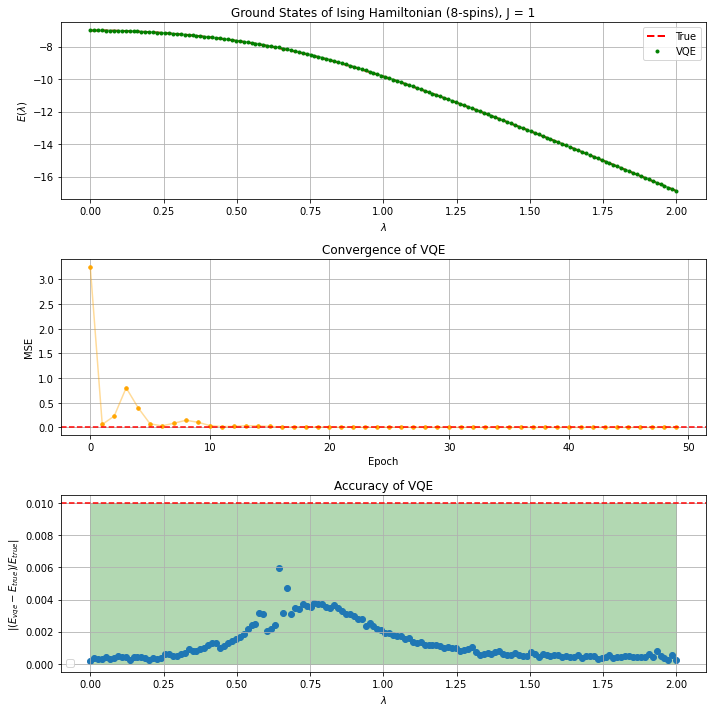

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(-0.47)──RX(-0.99)─╭C────────────────────||──RY(-0.76)──RX(0.15)──╭C──RY(-0.90)──────────
1: ──RY(-0.68)──RX(1.09)──╰X─╭C─────────────────||──RY(0.66)───RX(1.07)──╰X─╭C──────────RY(1.06)
2: ──RY(-0.43)──RX(-0.08)────╰X─╭C──────────────||──RY(-0.54)──RX(0.76)─────╰X─────────╭C───────
3: ──RY(0.42)───RX(-1.16)───────╰X─╭C───────────||──RY(0.08)───RX(0.61)────────────────╰X───────
4: ──RY(0.29)───RX(1.65)───────────╰X─╭C────────||──RY(0.25)───RX(-0.01)────────────────────────
5: ──RY(0.23)───RX(1.23)──────────────╰X─╭C─────||──RY(-0.54)──RX(0.46)─────────────────────────
6: ──RY(-1.87)──RX(-2.09)────────────────╰X─╭C──||──RY(0.03)───RX(-1.03)────────────────────────
7: ──RY(1.60)───RX(1.54)────────────────────╰X──||──RY(-1.65)──RX(-0.79)────────────────────────

──────────────────────────────────────────────────────┤ ╭<𝓗>
──────────────────────────────────────────────────────┤ ├<𝓗>
───RY(0.73)───────────────────────────────────────────┤ ├<𝓗>
──╭C─────────RY(0.15)───────────────────

  0%|          | 0/150 [00:00<?, ?it/s]

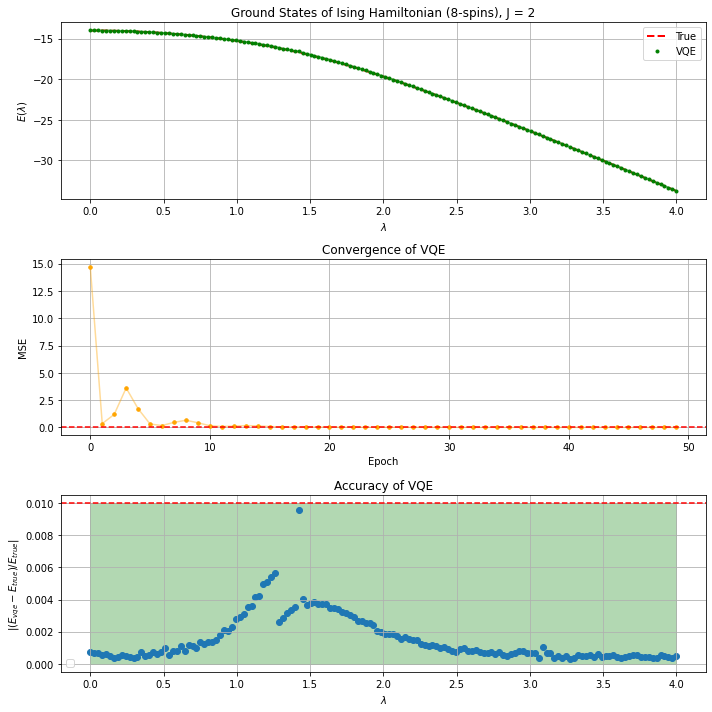

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)───RX(1.50)──╭C────────────────────||──RY(1.08)───RX(-0.73)─╭C──RY(0.83)───────────
1: ──RY(2.00)───RX(0.89)──╰X─╭C─────────────────||──RY(1.26)───RX(0.68)──╰X─╭C─────────RY(-0.38)
2: ──RY(0.98)───RX(-0.40)────╰X─╭C──────────────||──RY(1.25)───RX(-2.17)────╰X────────╭C────────
3: ──RY(0.47)───RX(2.23)────────╰X─╭C───────────||──RY(-0.35)──RX(0.24)───────────────╰X────────
4: ──RY(0.93)───RX(0.87)───────────╰X─╭C────────||──RY(-1.35)──RX(-0.34)────────────────────────
5: ──RY(-0.70)──RX(1.15)──────────────╰X─╭C─────||──RY(-1.15)──RX(0.18)─────────────────────────
6: ──RY(0.21)───RX(0.07)─────────────────╰X─╭C──||──RY(-0.48)──RX(-0.13)────────────────────────
7: ──RY(0.19)───RX(0.27)────────────────────╰X──||──RY(0.69)───RX(0.54)─────────────────────────

───────────────────────────────────────────────────────┤ ╭<𝓗>
───────────────────────────────────────────────────────┤ ├<𝓗>
───RY(0.57)────────────────────────────────────────────┤ ├<𝓗>
──╭C─────────RY(0.76)────────────────

  0%|          | 0/150 [00:00<?, ?it/s]

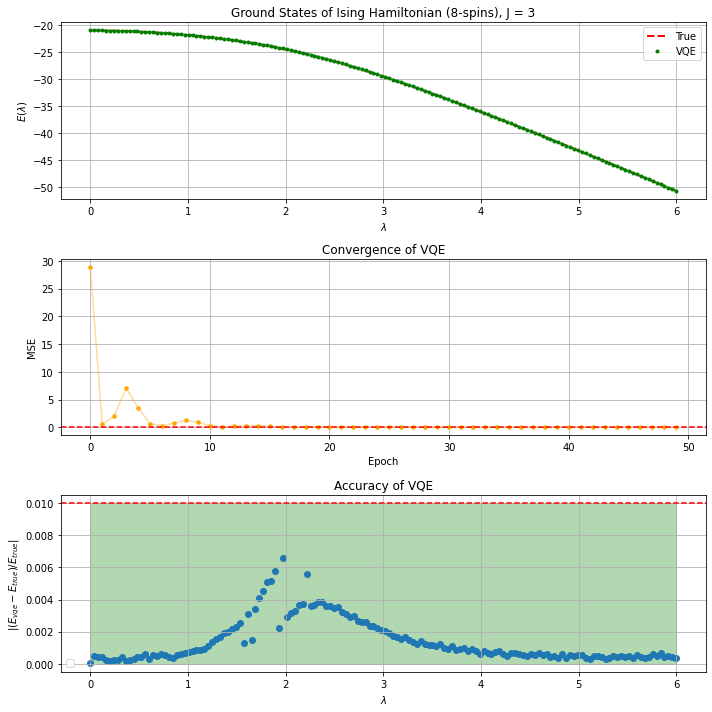

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(1.27)───RX(0.08)──╭C────────────────────||──RY(-1.25)──RX(0.93)──╭C──RY(-1.36)───────────
1: ──RY(1.07)───RX(0.69)──╰X─╭C─────────────────||──RY(2.28)───RX(1.49)──╰X─╭C──────────RY(-0.52)
2: ──RY(0.95)───RX(0.10)─────╰X─╭C──────────────||──RY(-1.14)──RX(0.91)─────╰X─────────╭C────────
3: ──RY(0.44)───RX(0.18)────────╰X─╭C───────────||──RY(1.33)───RX(0.15)────────────────╰X────────
4: ──RY(-0.49)──RX(-0.28)──────────╰X─╭C────────||──RY(1.93)───RX(-0.33)─────────────────────────
5: ──RY(0.18)───RX(1.12)──────────────╰X─╭C─────||──RY(0.66)───RX(0.68)──────────────────────────
6: ──RY(-0.54)──RX(-0.55)────────────────╰X─╭C──||──RY(0.68)───RX(-1.34)─────────────────────────
7: ──RY(0.55)───RX(1.38)────────────────────╰X──||──RY(-0.95)──RX(1.70)──────────────────────────

──────────────────────────────────────────────────────┤ ╭<𝓗>
──────────────────────────────────────────────────────┤ ├<𝓗>
───RY(-0.84)──────────────────────────────────────────┤ ├<𝓗>
──╭C──────────RY(-0.88)─────────

  0%|          | 0/150 [00:00<?, ?it/s]

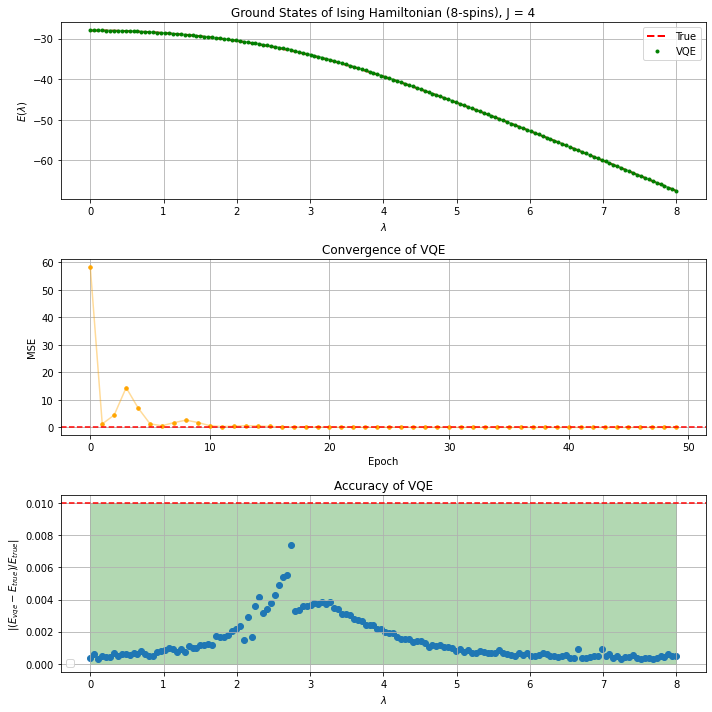

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(0.66)───RX(1.57)──╭C────────────────────||──RY(0.58)───RX(-1.30)─╭C──RY(0.67)──────────
1: ──RY(-0.51)──RX(-0.48)─╰X─╭C─────────────────||──RY(-0.73)──RX(-2.48)─╰X─╭C─────────RY(1.63)
2: ──RY(-0.26)──RX(0.91)─────╰X─╭C──────────────||──RY(-1.65)──RX(-0.34)────╰X────────╭C───────
3: ──RY(1.08)───RX(1.84)────────╰X─╭C───────────||──RY(1.66)───RX(1.48)───────────────╰X───────
4: ──RY(0.57)───RX(-2.40)──────────╰X─╭C────────||──RY(1.65)───RX(-1.17)───────────────────────
5: ──RY(-0.44)──RX(0.56)──────────────╰X─╭C─────||──RY(-1.27)──RX(-0.51)───────────────────────
6: ──RY(0.67)───RX(-0.49)────────────────╰X─╭C──||──RY(-1.22)──RX(1.08)────────────────────────
7: ──RY(0.29)───RX(0.87)────────────────────╰X──||──RY(-1.70)──RX(-2.28)───────────────────────

────────────────────────────────────────────────────────┤ ╭<𝓗>
────────────────────────────────────────────────────────┤ ├<𝓗>
───RY(-1.17)────────────────────────────────────────────┤ ├<𝓗>
──╭C──────────RY(1.23)────────────────────

  0%|          | 0/150 [00:00<?, ?it/s]

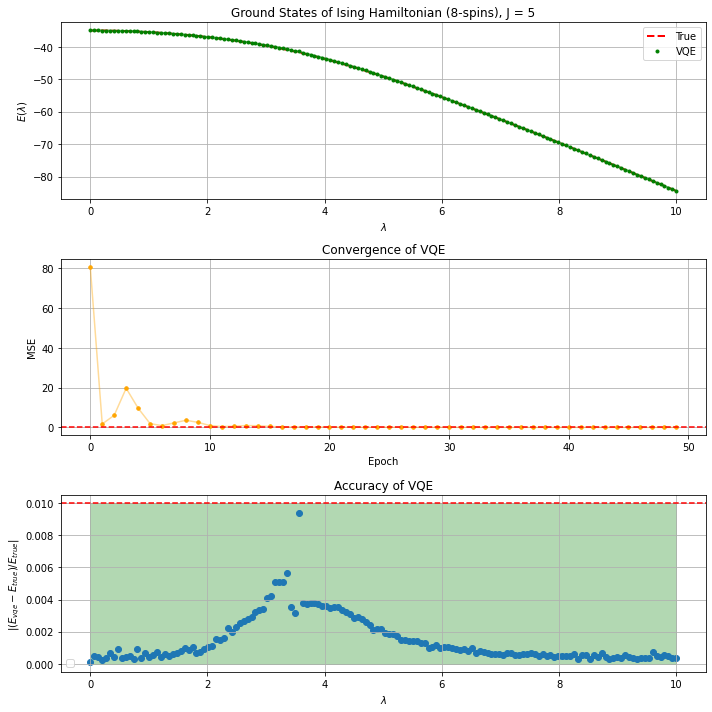

[[ 5.900e-02  1.581e+00  1.000e-03 ... -1.573e+00  1.510e+00 -1.531e+00]
 [ 5.900e-02  1.682e+00 -4.000e-03 ... -1.571e+00  1.446e+00 -1.496e+00]
 [ 6.200e-02  2.314e+00  1.010e-01 ... -1.581e+00  1.574e+00 -1.580e+00]
 ...
 [-1.521e+00  4.746e+00 -1.514e+00 ... -1.587e+00  1.557e+00 -1.553e+00]
 [-1.473e+00  4.702e+00 -1.535e+00 ... -1.560e+00  1.569e+00 -1.571e+00]
 [-1.446e+00  5.047e+00 -1.540e+00 ... -1.568e+00  1.574e+00 -1.570e+00]]


/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [4]:
for it_j, J in enumerate([1,2,3,4,5]):
    vqe_e, errs, thetas, ys = train_vqe_ising(step_size = 0.25, l_steps = 150, n_epochs = 50, N = 8, J = J,
                                              dev = dev_vqe, circuit = True, plots = True, first_epochs = 500)
    if it_j == 0:
        vqe_data_x = thetas 
        vqe_data_y = ys
    else:
        vqe_data_x = np.concatenate((vqe_data_x, thetas))
        vqe_data_y = np.concatenate((vqe_data_y, ys))
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_circuit_params.job')

print( np.round(np.asarray(thetas),3))

## Phase estimation through QCNN

In [4]:
dev_qcnn = qml.device('default.qubit.jax', wires=8)

In [6]:
# Load data and separate in training and test set
data_full = joblib.load('./vqe_circuit_params.job')

data_full = data_full[:300]

# Count the number of samples
samples_full = len(data_full)
X_test_J = data_full[(samples_full-150):] # Full dataset of J not trained
data = data_full[:(samples_full-150)]
samples = samples_full - 150

print('Size of Data Set: {0}'.format(samples))

train_index = np.random.choice(np.arange(samples), size=int(0.8*samples), replace=False )

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)

print('______________________________')
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))


Size of Data Set: 150
______________________________
Size of Training Set: 120
Size of Test Set    : 30


In [7]:
####################
## QCNN FUNCTIONS ##
####################

# QCNN circuit functions:

def convolution_8(params,N=8):
    '''
    Convolution layer of QCNN:
    Apply RX RZ to each wire and set entanglement to near spins through CNOTs
    '''
    k = 0
    
    for wire, wire_next in zip(range(0,N,2), range(1,N,2)):
        qml.RX(params[k], wires = wire)
        qml.RY(params[k+1], wires = wire)
    
        qml.CNOT(wires=[wire, wire_next])
    k = k + 2
    
    
    qml.Barrier()
    
    for wire, wire_next in zip(range(N-2,0,-2), range(N-3,-1,-2)):
        qml.RX(params[k], wires = wire_next)
        
        qml.CNOT(wires=[wire_next, wire])
        
    qml.Barrier()
        
    for wire, wire_next in zip(range(N-1,-1,-2), range(N-2,-1,-2)):
        qml.RX(params[k], wires = wire)
        qml.RY(params[k+1], wires = wire)
    
        qml.CNOT(wires=[wire, wire_next])
    k = k + 2

        
def pooling_8(params, N=8):
    '''
    Pooling layer of QCNN:
    Reduce the number of wires by measuring some and apply a 
    rotation to others based on the result of the measurement
    '''
    
    qml.Barrier()
    
    k = 3
    # First pooling 8->4
    for wire_meas, wire_next in zip(range(0,N,2), range(1,N,2)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RY)(params[k], wires=wire_next)
        k = k + 1
    
    qml.Barrier()
    
    # Second pooling 4->2
    for wire_meas, wire_next in zip(range(1,N,4), range(3,N,4)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        
    qml.Barrier()
    
    qml.RX(params[k], wires = 3)
    k = k + 1
    qml.RY(params[k], wires = 3)
    k = k + 1
    qml.RX(params[k], wires = 7)
    k = k + 1
    qml.RY(params[k], wires = 7)
    k = k + 1
    
    # Third pooling 2->1
    for wire_meas, wire_next in zip(range(3,N,8), range(7,N,4)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        
@qml.qnode(dev_qcnn, interface="jax", diff_method="best")     
def qcnn_8(params_vqe,params):
    '''
    QCNN circuit:
    VQE STATE PREPARATION + CONVOLUTION + POOLING
    '''
    vqe_circuit_1(params_vqe, 8)
    qml.Barrier()
    convolution_8(params)
    pooling_8(params)
    
    return qml.probs(wires=7)

# Estimation functions for QCNN

def cross_entropy(labels, predictions):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
        loss = loss + c_entropy

    return -1 * loss

def cost_fn(params, X, Y):
    fn = lambda v: qcnn_8(v, params)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)

    predictions = vcircuit(X)
    #predictions = [qcnn_8(x, params) for x in X]
    loss = cross_entropy(Y, predictions)
    
    return loss

def compute_accuracy(X, Y, params):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    data_len = len(X)
    fn = lambda v: qcnn_8(v, params)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)
    
    predictions = vcircuit(X)
    #print(jnp.argmax(predictions, axis=1)== Y)
    return (np.sum(jnp.argmax(predictions, axis=1)== Y))

# Training function

def qcnn_training(X_train, Y_train, X_test = [], Y_test = [], steps = 100, lr = 0.001, N = 8, plot = True, batch_size = 8):
    # Initialize parameters randomly
    params = jnp.array( np.random.randn(3*N + 2) )
    
    loss_history = []
    accuracy_history = []
    loss_history_test = []
    accuracy_history_test = []
    
    progress = tqdm(range(steps))
    
    n_batches      = jnp.shape(X_train)[0]//batch_size
    n_batches_test = jnp.shape(X_test)[0]//batch_size
    
    for epoch in progress:
        cost_tot = 0
        correctly_classified = 0
        # Compute current loss and update parameters
        for batch in range(n_batches):
            params_batch = copy.copy(params)
            
            start_batch = (batch)*(batch_size)
            end_batch = min( (batch+1)*(batch_size), jnp.shape(X_train)[0] )
            X_batch, Y_batch = jnp.array(X_train[start_batch:end_batch]), jnp.array(Y_train[start_batch:end_batch])
            circuit = lambda v: cost_fn(v, X_batch, Y_batch)
            grad_circuit = jax.grad(circuit)

            params -= lr*grad_circuit(params)
            cost_batch = circuit(params_batch)
            cost_tot = cost_tot + cost_batch
            
            correctly_classified += compute_accuracy(X_batch, Y_batch, params_batch)
            
            
        loss_history.append(cost_tot/jnp.shape(X_train)[0])
        accuracy = 100*correctly_classified/jnp.shape(X_train)[0]
        accuracy_history.append(accuracy)
        
        if len(X_test) > 0:
            cost_tot_test = 0
            correctly_classified_test = 0
            
            for batch in range(n_batches_test):
                start_batch = batch*(batch_size+1)
                end_batch = min( (batch+1)*(batch_size+1)-1, jnp.shape(X_test)[0] )
                #print(start_batch, end_batch)
                X_batch_test, Y_batch_test = jnp.array(X_test[start_batch:end_batch]), jnp.array(Y_test[start_batch:end_batch])
                #print(X_batch_test)
                circuit_test = lambda v: cost_fn(v, X_batch_test, Y_batch_test)
                
                cost_tot_test = cost_tot_test + circuit_test(params)
                correctly_classified_test =  correctly_classified_test + compute_accuracy(X_batch_test, Y_batch_test, params)
                
            loss_history_test.append(cost_tot_test/jnp.shape(X_test)[0])
            accuracy_history_test.append(100*correctly_classified_test/jnp.shape(X_test)[0])
        
        # Set description to current loss
        progress.set_description('Cost: {0} | Accuracy: {1}'.format(jnp.round(cost_tot,3), jnp.round(accuracy,2)))

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(steps), np.asarray(loss_history)/len(X_train), label = 'Training Loss')
        if len(X_test) > 0:
            plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
            plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(steps), accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(steps), accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

In [8]:
drawer = qml.draw(qcnn_8)
print(drawer([0]*100,[0]*100))

0: ──RY(0.00)──RX(0.00)─╭C────────────────────||──RY(0.00)──RX(0.00)─╭C──RY(0.00)──────────
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────────────────||──RY(0.00)──RX(0.00)─╰X─╭C─────────RY(0.00)
2: ──RY(0.00)──RX(0.00)────╰X─╭C──────────────||──RY(0.00)──RX(0.00)────╰X────────╭C───────
3: ──RY(0.00)──RX(0.00)───────╰X─╭C───────────||──RY(0.00)──RX(0.00)──────────────╰X───────
4: ──RY(0.00)──RX(0.00)──────────╰X─╭C────────||──RY(0.00)──RX(0.00)───────────────────────
5: ──RY(0.00)──RX(0.00)─────────────╰X─╭C─────||──RY(0.00)──RX(0.00)───────────────────────
6: ──RY(0.00)──RX(0.00)────────────────╰X─╭C──||──RY(0.00)──RX(0.00)───────────────────────
7: ──RY(0.00)──RX(0.00)───────────────────╰X──||──RY(0.00)──RX(0.00)───────────────────────

─────────────────────────────────────────────────────||──RX(0.00)──RY(0.00)─╭C──||───────────────||
─────────────────────────────────────────────────────||─────────────────────╰X──||──RX(0.00)─╭C──||
───RY(0.00)──────────────────────────────────────────||──RX(0.0

In [ ]:
loss_history, accuracy_history, params = qcnn_training(X_train, Y_train, X_test, Y_test, lr = 1e-0, steps = 100, batch_size = 16)

print('Final Loss: {0}\nFinal Accuracy: {1}%'.format(loss_history[-1], accuracy_history[-1]) )

  0%|          | 0/100 [00:00<?, ?it/s]

---
## Resources
* [Quantum Convolutional Neural Networks](https://arxiv.org/abs/1810.03787)
* [Machine Learning Phase Transitions with a Quantum Processor](https://arxiv.org/abs/1906.10155)

---
## Backup code

In [ ]:
@qml.qnode(dev)
def cost_fn_backup(param, m, J):
    vqe_ising_chain_circuit(param, 8)
    # return <psi|H|psi>
    H = qml_build_H(8, m, J)
    return qml.expval(H)

In [ ]:
for k in range(len(data)):
    J = data[k][0]
    x = np.linspace(0, 2*J, len(data[k][1]) )
    E_true = []
    E_pred = []
    for n, m in enumerate(x):
        Ham = qml_build_H(8, float(m), J)
        
        E_true.append(qml_compute_gs(Ham))
        E_pred.append(cost_fn_backup(data[k][1][n][0], float(m), J) )
        
    E_true = np.array(E_true)
    E_pred = np.array(E_pred)
    
    y = np.abs((E_true - E_pred)/E_true)
    
    print('J = {}'.format(J))
    
    plt.plot(x,y)
    plt.grid(True)
    plt.title('Accuracy of VQE states (J = {0})'.format(J))
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
    plt.show()